# Behavioral Cloning


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import cv2

import ntpath
import random

from imgaug import augmenters as ima

## Test Data from the Self-driving Car Simulator

This shows the directory structure and contents for this project.

In [2]:
!ls

CarND.yml                     drive_sdcar.py
Models                        images
README copy.md                model.ipynb
README.md                     output_images
Simulator                     sd_car_steering_model_v2.h5
Traffic_Sign_Classifier.ipynb self_driving_cars.yml
data                          video.py
drive.py


The `Data` directory contains the data generated by the simulator during training. I trained it in multiple runs. E.g., the data from one run is stored in `Driving Dataset 01`, while the data from a second run is stored in `Driving Dataset 02`. This notebook uses the second set of data I captured.

In [3]:
!ls "data/driving_dataset"

IMG             driving_log.csv


It captures images as `JPG` files from each of the three cameras, and stores them in the `Data/IMG` directory. The file `driving_log.csv` contains a summary of the data. We will explore its contents a little further down. 

In [4]:
!ls "data/driving_dataset/IMG" | wc -l

   35727


There are over 18,000 images in the test data set. These were genereated from performing 3 laps of the driving circuit, in each direction for a total of 6 laps. The reason I drove the car in both directions is to get a better dataset. Driving in one direction would resul in most of the turns being left turns or right turns, depending on the direction of driving. Driving the same number of times around the track in both directions gives a more even distribution of data, which I verify below.

Let's look at the first few images from the left camera, the center camera, and the right camera.

In [5]:
!ls "data/driving_dataset/IMG/" | grep 'left*' | head -3
!ls "data/driving_dataset/IMG/" | grep 'center*' | head -3
!ls "data/driving_dataset/IMG/" | grep 'right*' | head -3

left_2021_07_01_09_33_04_185.jpg
left_2021_07_01_09_33_04_289.jpg
left_2021_07_01_09_33_04_394.jpg
center_2021_07_01_09_33_04_185.jpg
center_2021_07_01_09_33_04_289.jpg
center_2021_07_01_09_33_04_394.jpg
right_2021_07_01_09_33_04_185.jpg
right_2021_07_01_09_33_04_289.jpg
right_2021_07_01_09_33_04_394.jpg


In [6]:
datadir = 'data/driving_dataset'
datafile = 'driving_log.csv'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
pd.set_option('display.max_colwidth', None)

data = pd.read_csv(os.path.join(datadir, datafile), names = columns)

In [7]:
data.head()

center  \
0  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/driving_dataset/IMG/center_2021_07_01_09_33_04_185.jpg   
1  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/driving_dataset/IMG/center_2021_07_01_09_33_04_289.jpg   
2  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/driving_dataset/IMG/center_2021_07_01_09_33_04_394.jpg   
3  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/driving_dataset/IMG/center_2021_07_01_09_33_04_501.jpg   
4  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/driving_dataset/IMG/center_2021_07_01_09_33_04_608.jpg   

                                                                                                                                                                  left  \
0   /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/driving_dataset/IMG/left_2021_07_01_09_33_04_185.jpg   
1   /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/driving_dataset/IMG/left_2021_07_01_09_33_04_289.jpg   
2   /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/driving_dataset/IMG/left_2021_07_01_09_33_04_394.jpg   
3   /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/driving_dataset/IMG/left_2021_07_01_09_33_04_501.jpg   
4   /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/driving_dataset/IMG/left_2021_07_01_09_33_04_608.jpg   

                                                                                                                                                                  right  \
0   /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/driving_dataset/IMG/right_2021_07_01_09_33_04_185.jpg   
1   /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/driving_dataset/IMG/right_2021_07_01_09_33_04_289.jpg   
2   /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/driving_dataset/IMG/right_2021_07_01_09_33_04_394.jpg   
3   /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/driving_dataset/IMG/right_2021_07_01_09_33_04_501.jpg   
4   /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/driving_dataset/IMG/right_2021_07_01_09_33_04_608.jpg   

   steering  throttle  reverse     speed  
0       0.0       0.0      0.0  0.000077  
1       0.0       0.0      0.0  0.000077  
2       0.0       0.0      0.0  0.000077  
3       0.0       0.0      0.0  0.000077  
4       0.0       0.0      0.0  0.000077

Remove the path from the filename entries of the images, leaving just the filename.

In [8]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)


In [9]:
data.head()

center                              left  \
0  center_2021_07_01_09_33_04_185.jpg  left_2021_07_01_09_33_04_185.jpg   
1  center_2021_07_01_09_33_04_289.jpg  left_2021_07_01_09_33_04_289.jpg   
2  center_2021_07_01_09_33_04_394.jpg  left_2021_07_01_09_33_04_394.jpg   
3  center_2021_07_01_09_33_04_501.jpg  left_2021_07_01_09_33_04_501.jpg   
4  center_2021_07_01_09_33_04_608.jpg  left_2021_07_01_09_33_04_608.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2021_07_01_09_33_04_185.jpg       0.0       0.0      0.0  0.000077  
1  right_2021_07_01_09_33_04_289.jpg       0.0       0.0      0.0  0.000077  
2  right_2021_07_01_09_33_04_394.jpg       0.0       0.0      0.0  0.000077  
3  right_2021_07_01_09_33_04_501.jpg       0.0       0.0      0.0  0.000077  
4  right_2021_07_01_09_33_04_608.jpg       0.0       0.0      0.0  0.000077

### Steering angle data
We will be using the steering angle data to train the network to steer the car. 

Plot the steering angles on a distribution, to see which angles are most frequent.

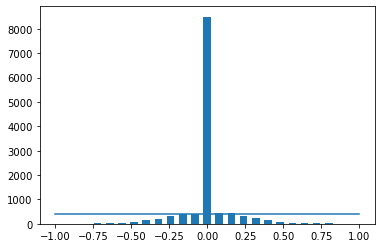

In [10]:
num_bins = 25
max_samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), 
          np.max(data['steering'])), 
         (max_samples_per_bin, max_samples_per_bin))

As might be expected, this shows that the angle of `0.0`, representing straight ahead, is the most common steering angle. However, for the purposes of training our neural network, this presents a problem because the center value dominate all other values, which would introduce bias in training our network.

The solution is to remove a set of the data from the center of the dataset, which results in a more normalized distribution of the data.

In [11]:
print('total data', len(data))
remove_list = []

for j in range(num_bins):
    list_ = []
    
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[max_samples_per_bin:]
    remove_list.extend(list_)
    
print('removed:', len(remove_list))

data.drop(data.index[remove_list], inplace=True)

print('remaining:', len(data))

total data 11909
removed: 8194
remaining: 3715


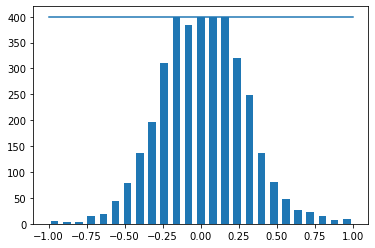

In [12]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), 
          np.max(data['steering'])), 
         (max_samples_per_bin, max_samples_per_bin))             

## Training and Validation Split

In [13]:
print(data.iloc[1])
def load_image_steering(datadir, df):
    image_path = []
    steering = []
    
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    
    return image_paths, steerings

image_paths, steerings = load_image_steering(datadir + '/IMG', data)

center      center_2021_07_01_09_33_07_302.jpg
left          left_2021_07_01_09_33_07_302.jpg
right        right_2021_07_01_09_33_07_302.jpg
steering                              -0.16467
throttle                                   0.0
reverse                                    0.0
speed                                 5.789322
Name: 30, dtype: object


In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, 
                                                      steerings, 
                                                      test_size=0.2, 
                                                      random_state=9)

print('Training samples: {}'.format(len(X_train)))
print('Validation samples: {}'.format(len(X_valid)))

Training samples: 2972
Validation samples: 743


Text(0.5, 1.0, 'Validation set')

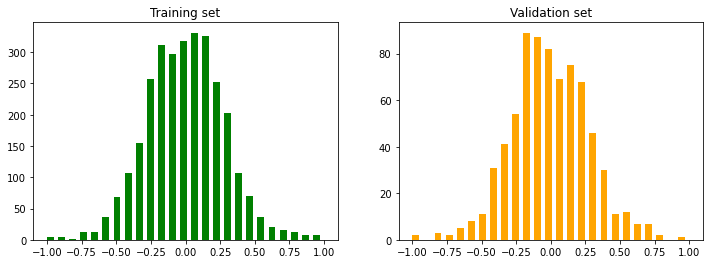

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='green')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='orange')
axes[1].set_title('Validation set')

## Generate additional data using augmentation techniques

As discussed in chapter 2 of the Dissertation document, applying augmentation techniques is a useful way to create more data from our existing data. This section of the notebook shows how I use zooming, panning, brightness, and flipping to create additional data for training the network. I then randomly apply multiple augmentations to the orginal data, so that, for example, one input image could result in an output image that is a variation that is flipped, rotated, and made brighter.

### Utility Functions

In [16]:
def plot_two_images(image1, image2, title1="Image 1", title2="Image 2"):
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    fig.tight_layout()

    axes[0].imshow(image1)
    axes[0].set_title(title1)

    axes[1].imshow(image2)
    axes[1].set_title(title2)

### Zooming

In [17]:
def zoom(image):
    zoom = ima.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

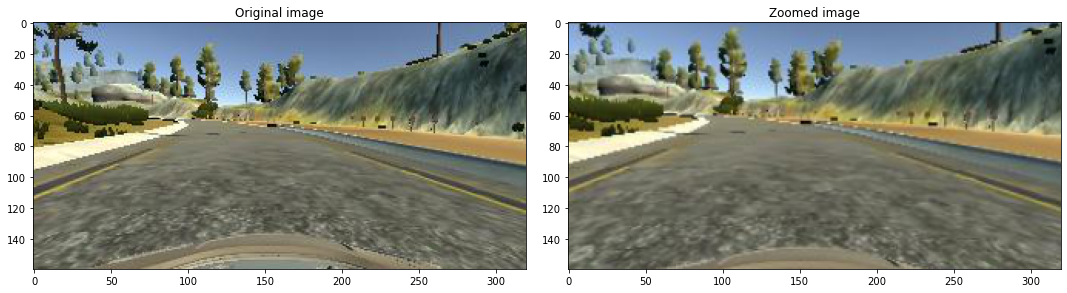

In [18]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

plot_two_images(original_image, zoomed_image, "Original image", "Zoomed image")

### Image panning

In [19]:
def pan(image):
    pan = ima.Affine(translate_percent={"x" : (-0.1, 0.1), "y" : (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

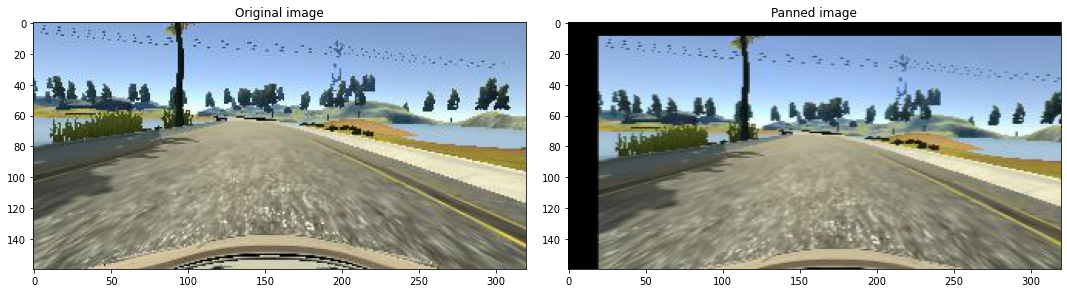

In [20]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

plot_two_images(original_image, panned_image, "Original image", "Panned image")

### Image brightness

In [21]:
def randomly_alter_brightness(image):
    brightness = ima.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

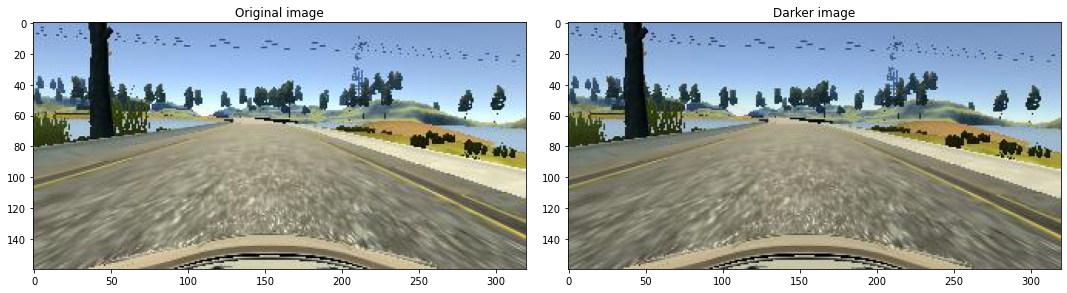

In [22]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
darker_image = randomly_alter_brightness(original_image)

plot_two_images(original_image, darker_image, "Original image", "Darker image")

### Flipping

In [23]:
def flip(image, steering_angle):
    HORIZONTAL_FLIP = 1
    image = cv2.flip(image, HORIZONTAL_FLIP)
    steering_angle = -steering_angle
    return image, steering_angle

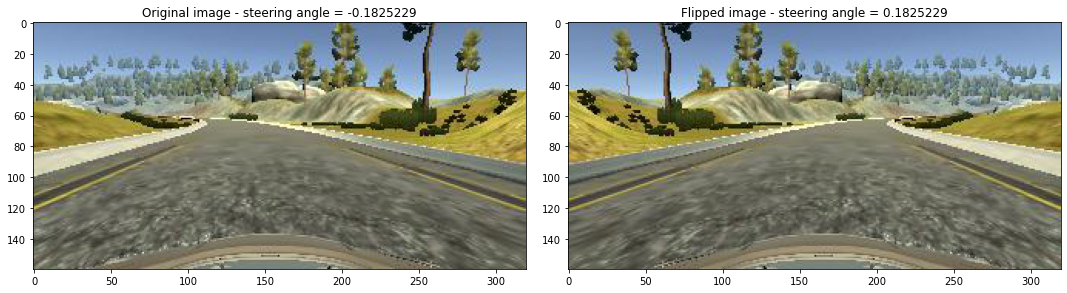

In [24]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = flip(original_image, steering_angle)

plot_two_images(
    original_image, 
    flipped_image, 
    "Original image - steering angle = {}".format(steering_angle), 
    "Flipped image - steering angle = {}".format(flipped_steering_angle)
)

### Randomly apply the augmentations
Note it may look like more than one transformation is being applied to a given original image, e.g., the augmented image may be flipped and darkened.

In [25]:
def random_augment(image, steering_angle):
    augmentation_types = []
    
    # we don't want any one transform used more than 50% of the time
    FREQUENCY_THRESHOLD = 0.5 
    
    image = mpimg.imread(image)
    
    if np.random.rand() < FREQUENCY_THRESHOLD:
        image = pan(image)
        augmentation_types.append("Pan")
    if np.random.rand() < FREQUENCY_THRESHOLD:
        image = zoom(image)
        augmentation_types.append("Zoom")
    if np.random.rand() < FREQUENCY_THRESHOLD:
        image = randomly_alter_brightness(image)
        augmentation_types.append("Brightness")
    if np.random.rand() < FREQUENCY_THRESHOLD:
        image, steering_angle = flip(image, steering_angle)
        augmentation_types.append("Flip")

    return image, steering_angle, augmentation_types

In [26]:
def plot_ten_random_augmented_images():
    columns = 2
    rows = 10

    fig, axs = plt.subplots(rows, columns, figsize=(15, 50))
    fig.tight_layout()

    for i in range(10):
        random_index = random.randint(0, len(image_paths) - 1)
        random_image = image_paths[random_index]
        random_steering_angle = steerings[random_index]

        original_image = mpimg.imread(random_image)
        augmented_image, augmented_steering_angle, augmentation_type = \
            random_augment(random_image, random_steering_angle)

        axs[i][0].imshow(original_image)
        axs[i][0].set_title("Original image - steering angle = {}"\
                            .format(random_steering_angle))
        axs[i][1].imshow(augmented_image)
        axs[i][1].set_title("Augmented image ({}) - steering angle = {}"\
                            .format(augmentation_type ,augmented_steering_angle))

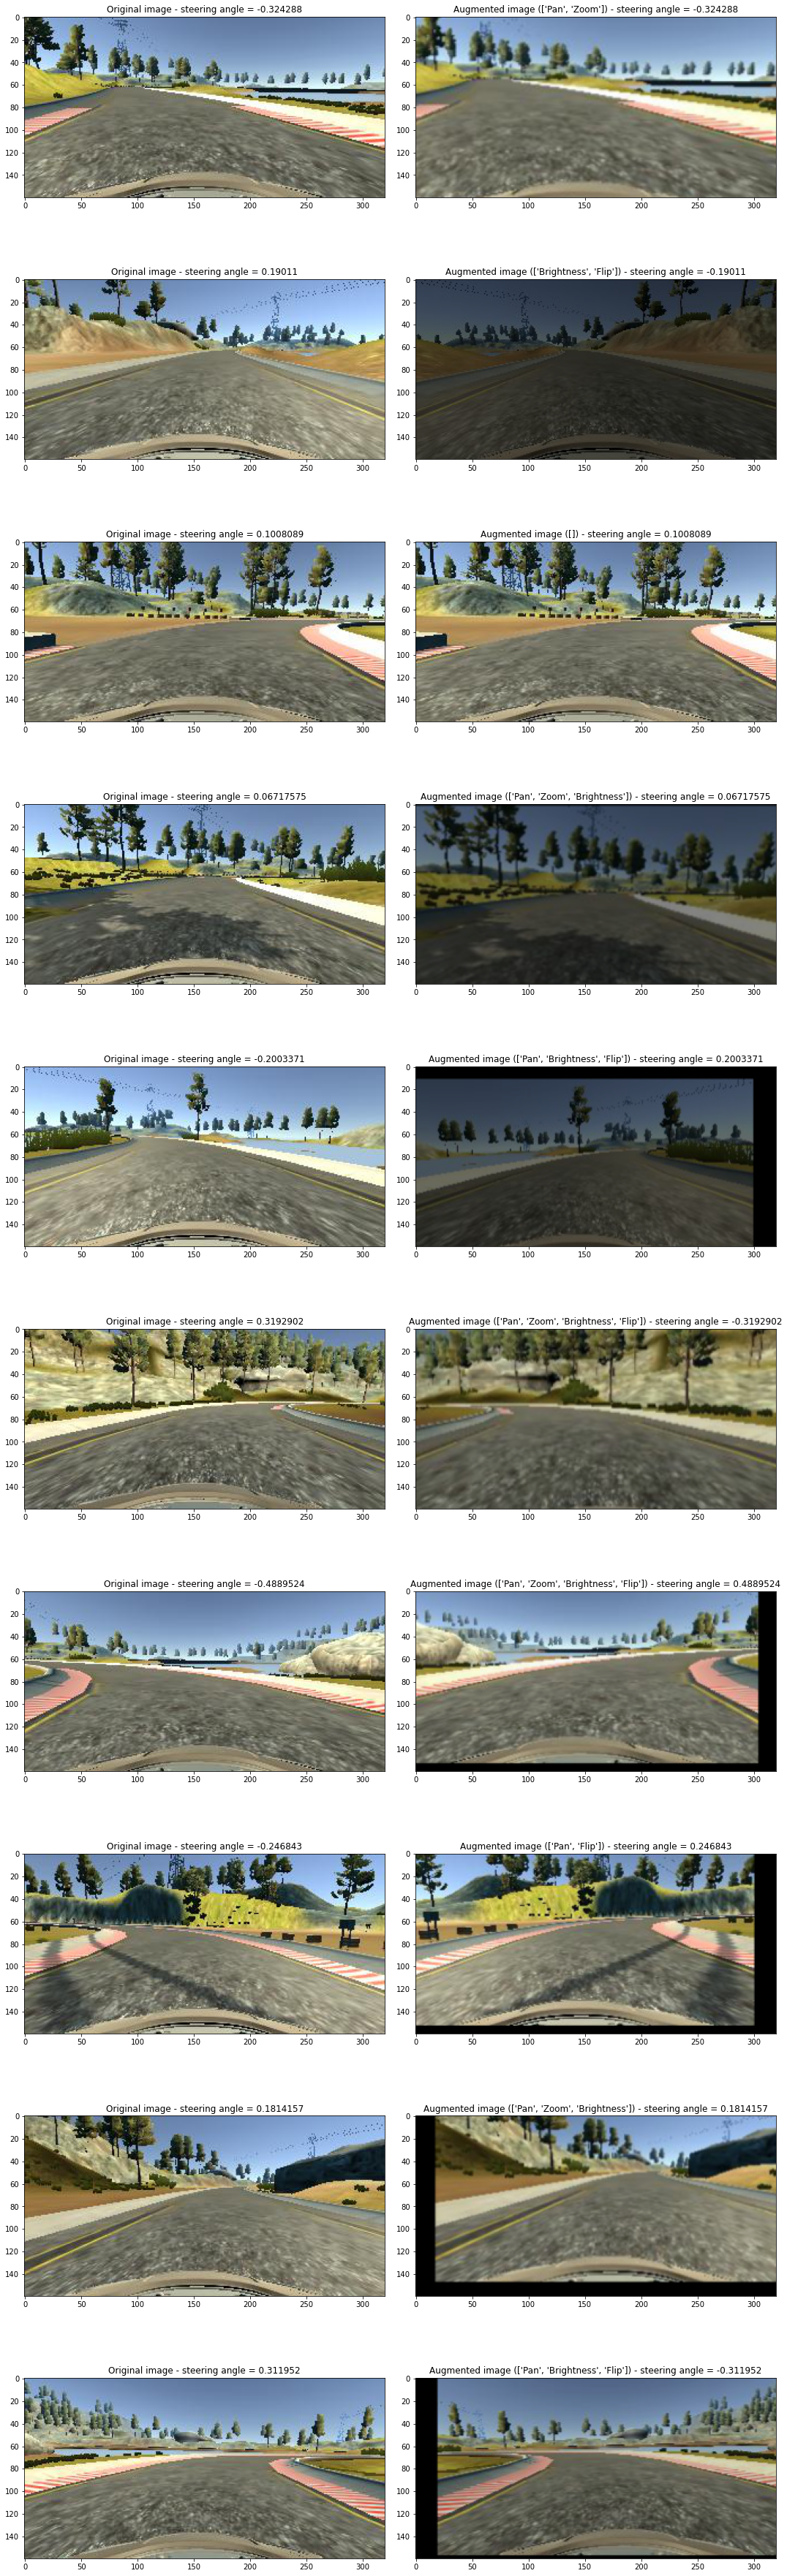

In [27]:
plot_ten_random_augmented_images()

## Preprocessing our data

In [28]:
top_of_image = 60
bottom_of_image = 135

def image_preprocess(image):
    image = image[top_of_image:bottom_of_image, :, :]
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    
    kernel_size = (3,3)
    image = cv2.GaussianBlur(image, kernel_size, 0)
    
    target_size = (200, 66) # per NVidia model recommendations
    image = cv2.resize(image, target_size)
    
    # normalize the image
    image = image/255
    
    return image

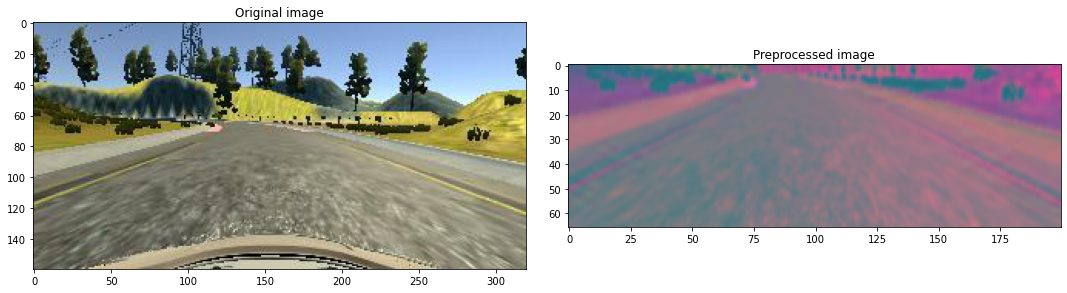

In [29]:
# select a random image to visualize
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = image_preprocess(original_image)

plot_two_images(original_image, 
                preprocessed_image, 
                "Original image", 
                "Preprocessed image")

### Batch Image Generator
The Batch Generator allows us to generate augmented images on the fly, when needed. 

In [30]:
def batch_generator(image_paths, steering_angles, batch_size, is_training):
        
        while True:
            batch_img = []
            batch_steering = []
            
            for i in range(batch_size):
                random_index = random.randint(0, len(image_paths) - 1)
                
                if is_training:
                    im, steering, aug_type = \
                        random_augment(image_paths[random_index], 
                                        steering_angles[random_index])
                else:
                    im = mpimg.imread(image_paths[random_index])
                    steering = steering_angles[random_index]
                    
                im = image_preprocess(im)
                batch_img.append(im)
                batch_steering.append(steering)
                
            yield (np.asarray(batch_img), np.asarray(batch_steering))

Plot images to verify our generator is working as expected.

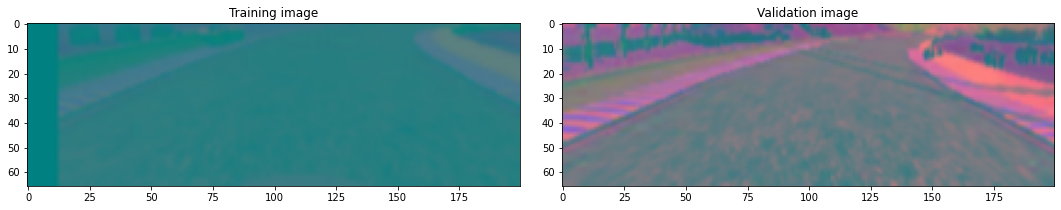

In [31]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

plot_two_images(x_train_gen[0], 
                x_valid_gen[0], 
                'Training image', 
                'Validation image')

## Defining NVidia Model Architecture for Behavioural Cloning
A popular model used for behavioural cloning is the one proposed by NVidia. It is also implemented in real-life self-driving cars.

We are going to implement this architecture from the paper by [Bojarski, et al. 2016](#References).

![CNN Architecture](./images/CNN_architecture.PNG)


We can see from the diagram that the Nvidia model begins with an Input layer (the Input planes at the bottom of the diagram), and then has a Normalization layer. We are going to skip the Normalization layer in our implementation because we have already normalized the data outside of our model, as part of the image processing. The normalized data is then passed into a convolutional layer.

Note, we can prevent overfitting by using a dropout layer in the model. Note, I experimented with Dropout Layers in different positions in the model at different times, and with varying dropout rates. Eventually, by experimenting with the hyperparameter values during training, I was able to reduce overfitting without the use of dropout layers.
    

In [39]:
def nvidia_model():
    model = Sequential(name="Vehicle_Control")
    
    stride_size = (2,2)
    
    image_height = 66
    image_width = 200
    number_of_channels = 3
    dropout_rate = 0.5
    learning_rate = 1e-4
    
    input_dimensions = (image_height, image_width, number_of_channels)
    
    model.add(Conv2D(24, (5, 5), stride_size, 
                            input_shape=input_dimensions, 
                            activation='elu', name='Convolutional_feature_map_24_31x98'))
    
    model.add(Conv2D(36, (5, 5), stride_size, activation='elu', name='Convolutional_feature_map_36_14x47'))
    model.add(Conv2D(48, (5, 5), stride_size, activation='elu', name='Convolutional_feature_map_48_5x22'))
    model.add(Conv2D(64, (3, 3), activation='elu', name='Convolutional_feature_map_64_3x20'))    
    model.add(Conv2D(64, (3, 3), activation='elu', name='Convolutional_feature_map_64_1x18'))    
    #model.add(Dropout(dropout_rate))

    model.add(Flatten(name='Flatten'))
    
    model.add(Dense(100, activation='elu', name='Fully_connected_100'))
    #model.add(Dropout(dropout_rate))

    model.add(Dense(50, activation='elu', name='Fully_connected_50'))
    #model.add(Dropout(dropout_rate))
    
    model.add(Dense(10, activation='elu', name='Fully_connected_10'))    
    #model.add(Dropout(dropout_rate))
    
    # outputs the predicted steering angle for our self-driving car
    model.add(Dense(1, name='Output_vehicle_control')) 
    
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mae'])
    
    return model

In [40]:
vehicle_control_model = nvidia_model()

print(vehicle_control_model.summary())

Model: "Vehicle_Control"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolutional_feature_map_24 (None, 31, 98, 24)        1824      
_________________________________________________________________
Convolutional_feature_map_36 (None, 14, 47, 36)        21636     
_________________________________________________________________
Convolutional_feature_map_48 (None, 5, 22, 48)         43248     
_________________________________________________________________
Convolutional_feature_map_64 (None, 3, 20, 64)         27712     
_________________________________________________________________
Convolutional_feature_map_64 (None, 1, 18, 64)         36928     
_________________________________________________________________
Flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
Fully_connected_100 (Dense)  (None, 100)           

## Training the model


In [41]:
batch_size = 100

training_generator = batch_generator(X_train, y_train, batch_size, True)
validation_generator = batch_generator(X_valid, y_valid, batch_size, False)

steps_per_epoch = 300 # len(X_train)//batch_size
validation_steps = 200 # len(X_valid)//batch_size 

epochs = 5

In [42]:
print(steps_per_epoch)
print(validation_steps)

300
200


In [43]:
history = vehicle_control_model.fit(training_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    epochs=epochs,
                                    validation_data=validation_generator,
                                    validation_steps=validation_steps,
                                    verbose=1,
                                    shuffle=1)

Epoch 1/5
300/300 [==============================] - 118s 372ms/step - loss: 0.0828 - accuracy: 0.1053 - mae: 0.2211 - val_loss: 0.0514 - val_accuracy: 0.1054 - val_mae: 0.1732
Epoch 2/5
300/300 [==============================] - 111s 372ms/step - loss: 0.0541 - accuracy: 0.1046 - mae: 0.1754 - val_loss: 0.0459 - val_accuracy: 0.1072 - val_mae: 0.1638
Epoch 3/5
300/300 [==============================] - 110s 368ms/step - loss: 0.0506 - accuracy: 0.1002 - mae: 0.1681 - val_loss: 0.0393 - val_accuracy: 0.1084 - val_mae: 0.1481
Epoch 4/5
300/300 [==============================] - 110s 369ms/step - loss: 0.0477 - accuracy: 0.1012 - mae: 0.1635 - val_loss: 0.0388 - val_accuracy: 0.1045 - val_mae: 0.1477
Epoch 5/5
300/300 [==============================] - 110s 369ms/step - loss: 0.0463 - accuracy: 0.1018 - mae: 0.1616 - val_loss: 0.0346 - val_accuracy: 0.1092 - val_mae: 0.1408


### Visualize the metrics

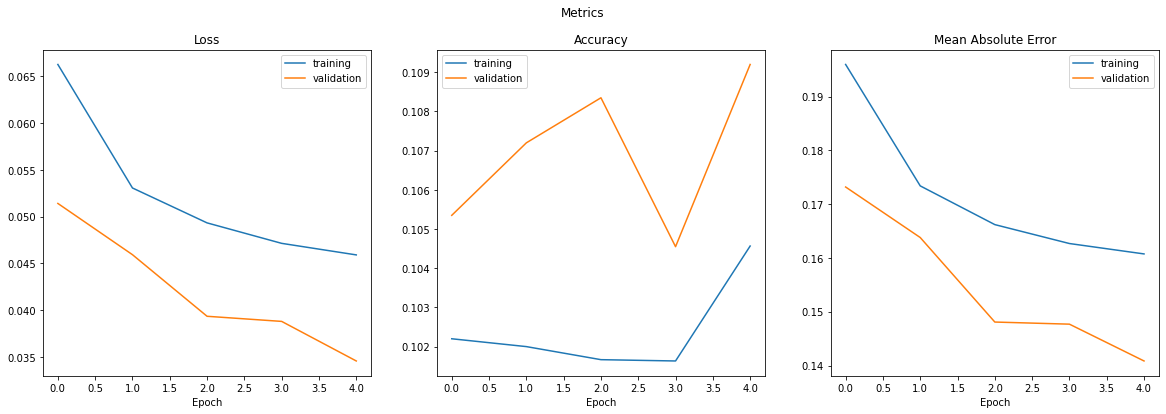

In [44]:
plt.figure(figsize=(20,6))
plt.suptitle("Metrics")


plt.subplot(131)
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.xlabel('Epoch')


plt.subplot(132)
plt.title('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.xlabel('Epoch')


plt.subplot(133)
plt.title('Mean Absolute Error')
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['training', 'validation'])
plt.xlabel('Epoch')

plt.show()

At this point, let's save the model, and verify it is saved to the specified location.

In [45]:
models_dir = 'Models'
model_name = 'model.h5'

vehicle_control_model.save(models_dir + '/' + model_name)

In [46]:
!ls $models_dir

model.h5                    sd_car_steering_model_v2.h5


This is the model I will use in the simulated vehicle. The self-driving car will use this model to control the steering.

# References
* Bojarski, M., Del Testa, D., Dworakowski, D., Firner, B., Flepp, B., Goyal, P., Jackel, L.D., Monfort, M., Muller, U., Zhang, J. and Zhang, X., 2016. [End to end learning for self-driving cars](https://arxiv.org/pdf/1604.07316.pdf). arXiv preprint arXiv:1604.07316.
